In [80]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn .metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import joblib

# Load cleaned data
data = pd.read_csv('../data/cleaned_superstore.csv')
data['order_date'] = pd.to_datetime(data['order_date'])
data.head()


,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,...,category,sub-category,product_name,sales,quantity,discount,profit,year,sales_per_quantity,month
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,2016,130.9800,11
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,2016,243.9800,11
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,2016,7.3100,6
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,2015,191.5155,10
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,2015,11.1840,10


In [81]:

data['order_date'] = pd.to_datetime(data['order_date'])


daily_sales=data.groupby('order_date')['sales'].sum().reset_index()
daily_sales.rename(columns={'order_date':'date','sales':'sales'},inplace=True)
daily_sales['sales'] = np.log1p(daily_sales['sales'])

print(daily_sales.head())


        date     sales
0 2014-01-03  2.859225
1 2014-01-04  5.666634
2 2014-01-05  3.022179
3 2014-01-06  8.391199
4 2014-01-07  4.479131


In [82]:
daily_sales['day'] = daily_sales['date'].dt.day
daily_sales['month'] = daily_sales['date'].dt.month
daily_sales['year'] = daily_sales['date'].dt.year
daily_sales['dayofweek'] = daily_sales['date'].dt.dayofweek   # 0 = Monday, 6 = Sunday

X = daily_sales[['day', 'month', 'year', 'dayofweek']]
y = daily_sales['sales']

print(X.head())



   day  month  year  dayofweek
0    3      1  2014          4
1    4      1  2014          5
2    5      1  2014          6
3    6      1  2014          0
4    7      1  2014          1


In [83]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)



Train size: (989, 4)
Test size: (248, 4)


In [84]:
model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)
print("✅ Random Forest model trained successfully!")


✅ Random Forest model trained successfully!


In [85]:

y_pred = model.predict(X_test)

results = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
})
results.head()



,Actual,Predicted
0,8.041836,5.667229
1,8.190544,7.087981
2,7.988250,7.749348
3,7.724894,5.502034
4,8.087603,6.711364


In [86]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
#r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
#print(f"R² Score: {r2:.4f}")


MAE: 1.10
RMSE: 1.44


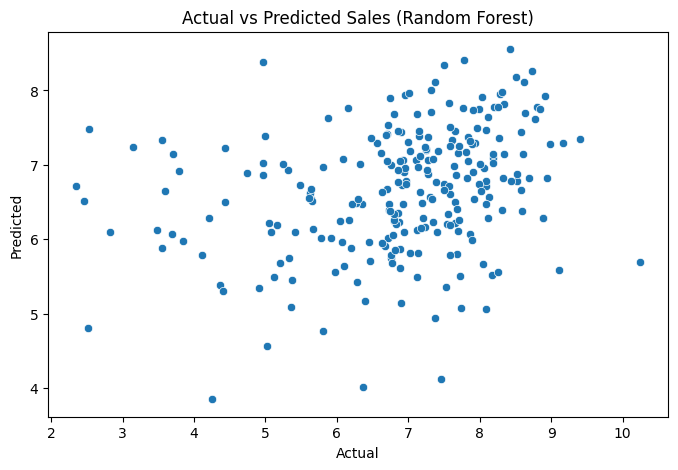

In [87]:
import seaborn as sns
plt.figure(figsize=(8,5))
sns.scatterplot(x='Actual', y='Predicted', data=results)
plt.title("Actual vs Predicted Sales (Random Forest)")
plt.show()


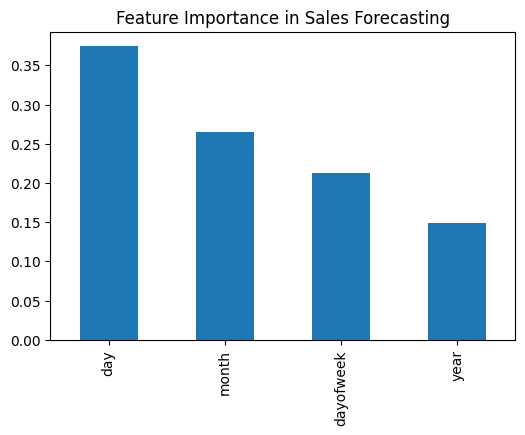

In [88]:
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(6,4))
plt.title("Feature Importance in Sales Forecasting")
plt.show()


In [89]:
# get the last available date in your dataset
last_date = daily_sales['date'].max()

# create the next 7 days (beyond the last date)
future_dates = pd.date_range(start=last_date, periods=8, inclusive='neither')

# create a new dataframe with these dates and their date features
future_df = pd.DataFrame({
    'date': future_dates,
    'day': future_dates.day,
    'month': future_dates.month,
    'year': future_dates.year,
    'dayofweek': future_dates.dayofweek
})

# predict future sales using your trained model
future_df['predicted_sales'] = model.predict(
    future_df[['day', 'month', 'year', 'dayofweek']]
)

# preview results
print(future_df[['date', 'predicted_sales']])

# save to CSV
future_df.to_csv('../data/superstore_sales_forecast_rf.csv', index=False)
print("✅ Saved forecast to data/superstore_sales_forecast_rf.csv")



        date  predicted_sales
0 2017-12-31         6.459155
1 2018-01-01         7.318667
2 2018-01-02         7.347389
3 2018-01-03         7.368056
4 2018-01-04         6.901367
5 2018-01-05         6.962404
6 2018-01-06         7.479170
✅ Saved forecast to data/superstore_sales_forecast_rf.csv


In [90]:
joblib.dump(model, '../model/superstore_sales_rf.pkl')
print("✅ Model saved as models/superstore_sales_rf.pkl")


✅ Model saved as models/superstore_sales_rf.pkl
